In [1]:
import os
# os.chdir('../../../')
import sys
sys.path.append("/home/chi/PhishIntention/phishintention")
# print(sys.path)
from src.OCR_aided_siamese import *
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
import pandas as pd

data_path = '/home/chi/PhishIntention/new_test_data/test_recog_data/'
pn_gb_path = data_path + 'pn_gb/'

detect_coor = data_path + "detect_coor.txt"
manual_coor = data_path + "manual_coor.txt"

detect_annot = [x.strip().split(',') for x in open(detect_coor).readlines()]
manual_annot = [x.strip().split(',') for x in open(manual_coor).readlines()]
detect_annot_dict = {}
manual_annot_dict = {}

# inital pred_annot_dict and gt_annot_dict
# it is possible that there are several detected logo rectangles in one screenshot
# for c in detect_annot:
#     assert len(c) == 5
#     x1, y1, x2, y2 = map(float, c[1:])
#     if c[0] not in list(detect_annot_dict.keys()):
#         detect_annot_dict[c[0]] = np.asarray([[x1, y1, x2, y2]])
#     else:
#         detect_annot_dict[c[0]] = np.append(detect_annot_dict[c[0]], [[x1, y1, x2, y2]], axis=0)

for c in manual_annot:
    if len(c) != 5:
        print(c, len(c))
    assert len(c) == 5
    x1, y1, x2, y2 = map(float, c[1:])
    manual_annot_dict[c[0]] = np.asarray([[x1, y1, x2, y2]])

for c in detect_annot:
    if len(c) != 5:
        print(c, len(c))
    assert len(c) == 5
    x1, y1, x2, y2 = map(float, c[1:])
    detect_annot_dict[c[0]] = np.asarray([[x1, y1, x2, y2]])

/home/chi/miniconda3/envs/py37/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pedia_model, ocr_model, logo_feat_list, file_name_list = phishpedia_config_OCR(num_classes=277,
                                                weights_path='/home/chi/PhishIntention/phishintention/src/OCR_siamese_utils/output/targetlist_lr0.01/bit.pth.tar',
                                                ocr_weights_path='/home/chi/PhishIntention/phishintention/src/OCR_siamese_utils/demo_downgrade.pth.tar',
                                                targetlist_path='/home/chi/PhishIntention/phishintention/src/phishpedia_siamese/expand_targetlist')

domain_map_path = '/home/chi/PhishIntention/phishintention/src/phishpedia_siamese/domain_map.pkl'

  0%|          | 0/277 [00:00<?, ?it/s]/home/chi/miniconda3/envs/py37/lib/python3.7/site-packages/torch/nn/functional.py:4228: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
 57%|█████▋    | 157/277 [09:22<05:11,  2.60s/it]

In [89]:
print("Here are " + str(len(logo_feat_list)) + " logo feats")
print("Here are " + str(len(file_name_list)) + " logo feats")
facebook_feat_list = []
color_array = ['red', 'blue', 'green']
colors, labels = [], []
for i, name in enumerate(file_name_list):
    if 'Facebook' in name:
        facebook_feat_list.append(logo_feat_list[i])
        colors.append(color_array[1])
        labels.append("Facebook")
    else:
        colors.append(color_array[0])
        labels.append("others")

facebook_feat_list = np.array(facebook_feat_list)
print("Here are " + str(len(facebook_feat_list)) + " facebook logo feats")

Here are 3064 logo feats
Here are 3064 logo feats
Here are 30 facebook logo feats


In [59]:
%matplotlib inline
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_tsne(feats, colors, labels, per=40):
    """
    Args:
        feats: torch.Tensor of shape [N, C]
        labels: torch.Tensor of shape [N]
    TODO: 
        Visualize features as 2D points using t-SNE.
    """
    data = TSNE(n_components = 2, perplexity = per).fit_transform(feats)
    x = data[:, 0]
    y = data[:, 1]
    color = ['red', 'blue', 'green']
    for i in range(len(x)):
      plt.scatter(x[i], y[i], c=colors[i], label=labels[i],  s=10)
    plt.show()

/home/chi/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/chi/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


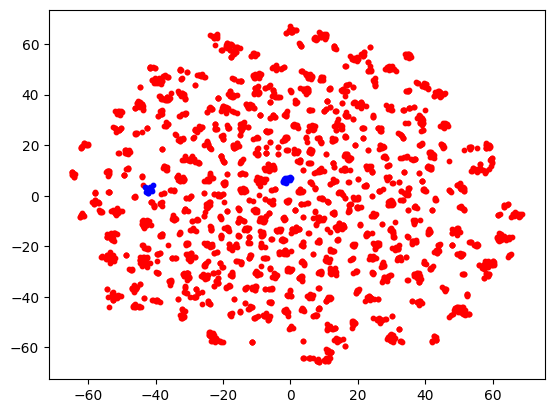

In [60]:
plot_tsne(logo_feat_list, color_array)
# print(logo_feat_list)

In [3]:
idx = np.random.randint(1000, size = 100)
i = 0
ct_wrong_reg = 0

In [4]:
import shutil
def load_results(pred_boxes_list, img_path):
    img = cv2.imread(img_path)
    if pred_boxes_list is not None:
        for pred_boxes in pred_boxes_list:
            cv2.rectangle(img, (int(pred_boxes[0]), int(pred_boxes[1])), (int(pred_boxes[2]), int(pred_boxes[3])), (0, 0, 255), 2)

    # shutil.copy('/home/chi/PhishIntention/new_test_data/all_logo_in_dataset/'+path, result_path)
    # os.system("cp /home/chi/PhishIntention/new_test_data/detect_results/"+path+ " "+result_path )


In [68]:
manual_feat_list, detect_feat_list = [], []

# For every screenshot of webpage
dataset_path = pn_gb_path
for path in tqdm(os.listdir(dataset_path)):
# for path in tqdm(os.listdir('/home/chi/PhishIntention/logo_reg_dataset/Sample_benign1000')):
    # print("image ", path)
    i += 1
    url = '' # dummy value, not important
    img_path = dataset_path + path

    manual_boxes = manual_annot_dict[path[:-4]][0]
    detect_boxes = detect_annot_dict[path[:-4]][0]

    pred_classes = np.zeros(manual_boxes.shape[0])
    logo_boxes = manual_boxes[pred_classes==0]
    try:
        img = Image.open(img_path)
    except OSError:  # if the image cannot be identified, return nothing
        print('Screenshot cannot be open')

    ## get predicted box --> crop from screenshot
    manual_cropped = img.crop((manual_boxes[0], manual_boxes[1], manual_boxes[2], manual_boxes[3]))
    detect_cropped = img.crop((detect_boxes[0], detect_boxes[1], detect_boxes[2], detect_boxes[3]))

    manual_img_feat = pred_siamese_OCR(manual_cropped, pedia_model, ocr_model, imshow=False, title='Original rcnn box', grayscale=False)
    detect_img_feat = pred_siamese_OCR(detect_cropped, pedia_model, ocr_model, imshow=False, title='Original rcnn box', grayscale=False)

    manual_feat_list.append(manual_img_feat)
    detect_feat_list.append(detect_img_feat)



  0%|          | 0/25 [00:00<?, ?it/s]/home/chi/miniconda3/envs/py37/lib/python3.7/site-packages/torch/nn/functional.py:4228: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
100%|██████████| 25/25 [00:16<00:00,  1.54it/s]


In [87]:
manual_feat_list = np.array(manual_feat_list)
detect_feat_list = np.array(detect_feat_list)

webpage_feat_list = np.concatenate((manual_feat_list, detect_feat_list), axis=0)

labels_manual = np.zeros(len(manual_feat_list), dtype=int)
labels_detect = np.ones(len(detect_feat_list), dtype=int)
labels = np.concatenate((labels_manual, labels_detect), axis=0)

/home/chi/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/chi/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


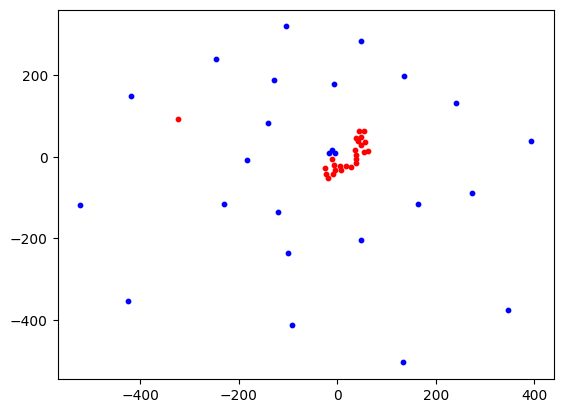

In [88]:
plot_tsne(webpage_feat_list, labels, per=10)
# color = ['red', 'blue', 'green']
# red is manual, blue is detect

In [92]:
feat_list = np.concatenate((facebook_feat_list, manual_feat_list, detect_feat_list))
label_target = np.zeros(len(facebook_feat_list), dtype=int)    # target = 0, red
label_manual = np.ones(len(manual_feat_list), dtype=int)       # manual = 1, blue
label_detect = np.full(len(detect_feat_list), 2, dtype=int)    # detect = 2, green
labels = np.concatenate((label_target, label_manual, label_detect))

In [ ]:
for i in range(5):
    sim_manual = facebook_feat_list @ manual_feat_list[i].T

/home/chi/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/chi/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


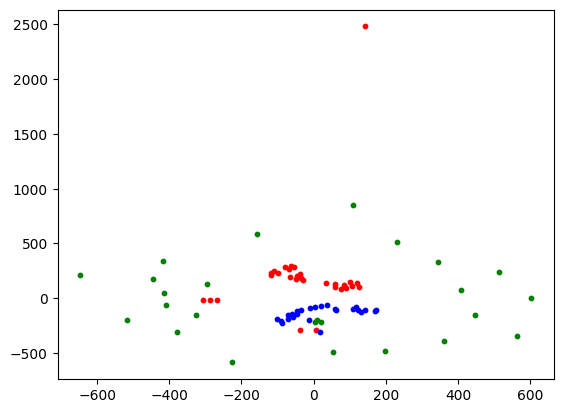

/home/chi/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/chi/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


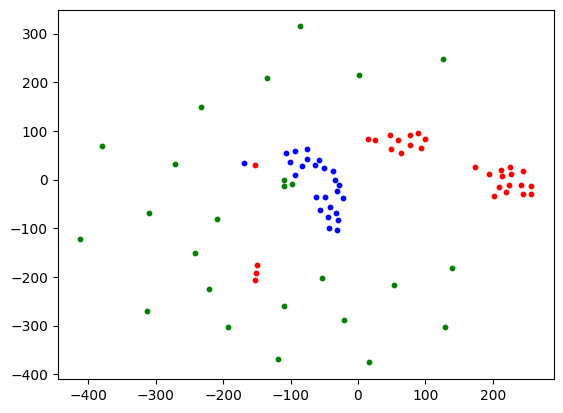

/home/chi/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/chi/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


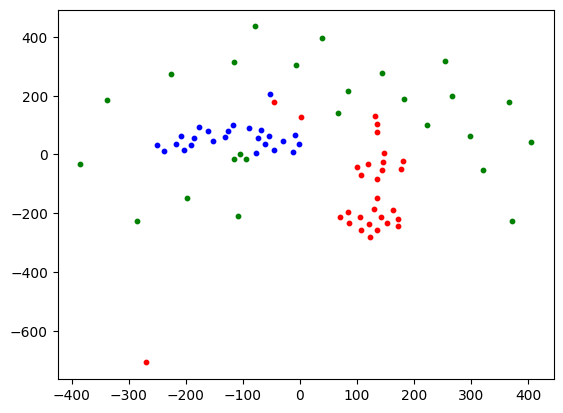

/home/chi/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/chi/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


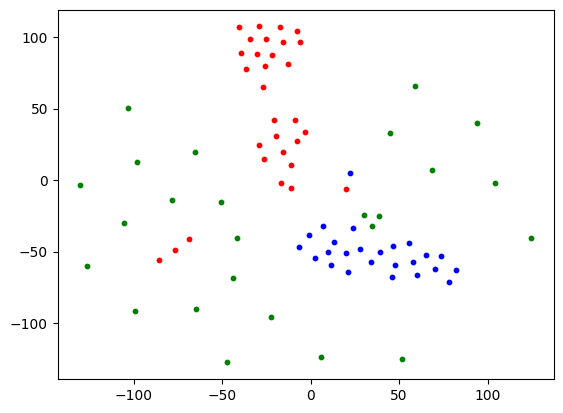

/home/chi/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/chi/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


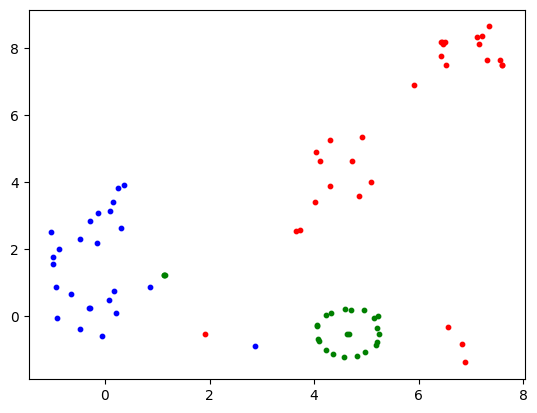

/home/chi/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/chi/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


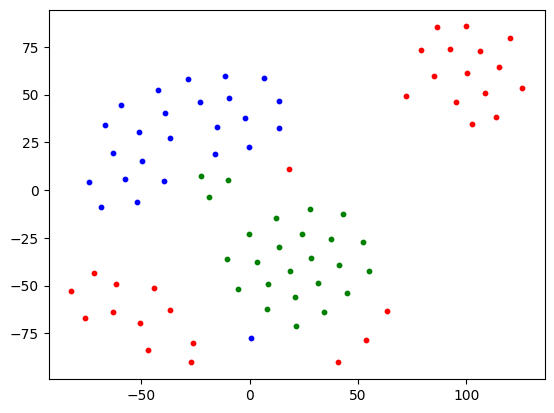

In [99]:
for p in range(5, 35, 5):
    plot_tsne(feat_list, labels, per=p)